In [1]:
import sys
sys.path.append("/opt/ml/code/")

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

import re
import math

import model_encoder

# 데이터 로딩

In [3]:
df = pd.read_json('../../data/wikipedia_documents.json').T

## 중복 데이터 제거

In [4]:
df = df.drop_duplicates(subset=['text'])
df.nunique()

text             56737
corpus_source        1
url                  1
domain               0
title            31726
author               0
html                 0
document_id      56737
dtype: int64

## 데이터 길이 분포 분석

In [5]:
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [7]:
def tokenized_len(row):
  return len(tokenizer.tokenize(row))

In [8]:
df['tokenizedCount'] = df['text'].apply(tokenized_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (1131 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:xlabel='tokenizedCount', ylabel='Count'>

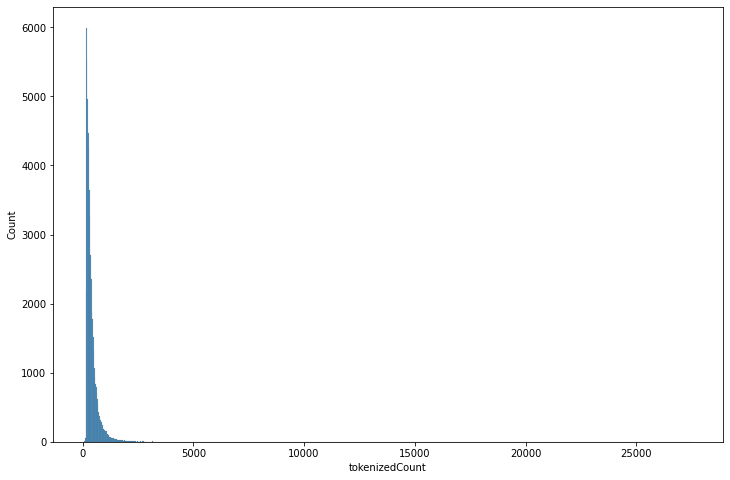

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(x='tokenizedCount', data=df, bins=1000)

In [10]:
df['tokenizedCount'].describe()

count    56737.000000
mean       401.889208
std        392.152975
min         54.000000
25%        221.000000
50%        308.000000
75%        457.000000
max      27539.000000
Name: tokenizedCount, dtype: float64

# 위키데이터 쪼개기

In [12]:
splited_documents = []
count = 0
for index, document in tqdm(df.iterrows()):
  # print("==================count=====================",count)
  
  original_passage = document['text']

  length_of_tokenized_text = len(tokenizer.tokenize(original_passage))

  number_of_passages_to_create = math.ceil(length_of_tokenized_text / 400)  # 510으로 안하는 이유는 110만큼의 buffer를 주기 위해서
  min_required_length = length_of_tokenized_text // number_of_passages_to_create  # 최소 길이
  max_possible_length = min_required_length + 110  # 최대길이

  end_of_sentences = re.findall(r'[가-힣]+\S*\.', original_passage)
  sentences = re.split(r'[가-힣]+\S*\.', original_passage)
  sentence_counter = 0


  # print(min_required_length)
  for i in range(number_of_passages_to_create):
    partial_text = ''
    partial_text_length = 0

    if sentence_counter == len(end_of_sentences)-1:
      break
    
    for j in range(len(sentences) - 1):
      partial_text += sentences[sentence_counter] + end_of_sentences[sentence_counter]
      partial_text_length += len(tokenizer.tokenize(sentences[sentence_counter] + end_of_sentences[sentence_counter]))
      # print('==============================', sentence_counter, len(sentences)-1, len(end_of_sentences)-1)
      # print(partial_text, partial_text_length)
      sentence_counter += 1
      if partial_text_length >= min_required_length or sentence_counter == len(end_of_sentences)-1:
        
        if sentence_counter == len(end_of_sentences)-1:
          partial_text += sentences[-1]
        document_to_be_added = {
          'text': partial_text,
          'title': document['title'],
          'document_id': count # document['document_id']
        }

        splited_documents.append(document_to_be_added)
        count +=1
        break
print("length of data after split: ", len(splited_documents))

56737it [03:16, 289.35it/s]


## 엘라스틱서치 연결

In [6]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}])
es.ping()

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


True

### 인덱스 목록 보기

In [7]:
res = es.indices.get_alias("*")
for Name in res:
  print(Name)

wiki_documents
.kibana_task_manager_7.15.1_001
wiki_documents_dense
wiki_documents_splited
.apm-custom-link
.kibana-event-log-7.15.1-000001
.apm-agent-configuration
.tasks
.kibana_7.15.1_001
wiki_documents_splited_dense


/tmp/ipykernel_15169/3052314421.py:1: DeprecationWarning: Using positional arguments for APIs is deprecated and will be disabled in 8.0.0. Instead use only keyword arguments for all APIs. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.indices.get_alias("*")
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: this request accesses system indices: [.kibana_task_manager_7.15.1_001, .apm-custom-link, .apm-agent-configuration, .tasks, .kibana_7.15.1_001], but in a future major version, direct access to system indices will be prevented by default
  warnings.warn(message, category=ElasticsearchWarning)


### 인덱스 삭제하기

In [ ]:
# es.indices.delete(index='wiki_documents_splited', ignore=[400, 404])

## 쪼깨진 위키데이터 입력

### 쪼갠 위키데이터를 입력하기 위한 제너레이터

In [ ]:
def generator(splited_documents):
  for c, line in enumerate(splited_documents):
    yield {
      '_index': 'wiki_documents_splited',
      '_type': '_doc',
      '_id': line.get('document_id', None),
      '_source': {
        'title': line.get('title', ''),
        'text': line.get('text', '')
      }
    }
  raise StopIteration

In [ ]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'title':{
        'type':'text'
      },
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      }
    }
  }
}

In [ ]:
es.indices.create(index='wiki_documents_splited', ignore=[400,404], body=CONFIG)

In [ ]:
gen = generator(splited_documents)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

# 쪼갠 위키데이터 Dense Embedding해서 넣기

In [62]:
p_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/p_encoder_neg').to('cuda')

In [63]:
p_embs = []
for document in tqdm(splited_documents):
  with torch.no_grad():
    p_encoder.eval()
    p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510).to('cuda')

    p_emb = p_encoder(**p_val)
    p_embs.append(p_emb[0].cpu().detach().numpy().tolist())
    

100%|██████████| 78411/78411 [20:55<00:00, 62.45it/s]


In [64]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      },
      'vector':{
        'type':'dense_vector',
        'dims':768
      }
    }
  }
}

In [65]:
es.indices.delete(index='wiki_documents_splited_dense', ignore=[400, 404])
es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/tmp/ipykernel_2540/2407913785.py:2: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_splited_dense', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_splited_dense'}

In [66]:
def generator(splited_documents, p_embs):
  for document, vector in zip(splited_documents, p_embs):
    yield {
      '_index': 'wiki_documents_splited_dense',
      '_type': '_doc',
      '_id': document.get('document_id', None),
      '_source': {
        'text': document.get('text', ''),
        'vector': vector
      }
    }
  raise StopIteration

In [67]:
gen = generator(splited_documents, p_embs)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


generator raised StopIteration
Done


## 검증해보기

In [74]:
q_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')

In [80]:
query = '대한민국의 대통령은 누구인가?'

In [81]:
with torch.no_grad():
  q_encoder.eval()
  q_val = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt', max_length = 510).to('cuda')

  q_emb = q_encoder(**q_val)
  q_output = q_emb[0].cpu().detach().numpy().tolist()

In [97]:
res = es.search(
  index='wiki_documents_splited_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          },
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          # "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 10
)

/tmp/ipykernel_10369/3671833892.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [98]:
for i in range(10):
  print(res['hits']['hits'][i]['_score'])

1.0137191
1.0114226
1.0108639
1.01084
1.0100178
1.00925
1.0047284
1.0042971
1.0031106
1.0029849


In [84]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

 1948년 대한민국 대통령 선거가 1948년 5월 10일 열렸고, 대통령으로 이승만이 선출되었다. 1948년 8월 15일 대한민국 정부가 수립되었고, 9월 9일 조선민주주의인민공화국이 수립되어 김일성이 총리로 임명되었다. 이 두 정부의 출현은 한반도의 분단을 고착화시켰다. 소련군은 1948년 12월 10일 떠났고, 이틀 후 대한민국 정부는 유엔으로부터 한반도 유일의 합법 정부로 인정받았다. 1949년 미군이 한반도를 떠났지만 주한 미군 군사 고문단이 대한민국에 남아있었다. 두 정부는 국명 또한 달랐는데 북측은 조선이라는 국명을 채택했고, 남측은 대한이라는 이름을 채택했다. \n\n두 정부는 서로가 한반도 유일의 정부라고 주장했고, 분단이 일시적인 것이라고 보았다. 김일성은 이오시프 스탈린과 마오쩌둥을 설득해 통일 전쟁을 준비했고, 이승만은 북진에 대한 열망을 포기하지 않았다. 1948년 북한은 남한으로 이어진 전기선을 모두 차단했다. 전쟁이 발발하기 직전까지 옹진군과 개성 일대를 비롯한 38도선 일대에서 국지적 분쟁이 발생했다. \n\n이 시기 동안 여수·순천 사건과 제주 4·3 사건 등 남한에서는 다양한 반란이 일어나 탄압되었다.
워터게이트 당시 미국 공화당 리처드 닉슨 대통령이 자신의 범죄증거가 되는 녹음테이프를 발견한 특별검사를 즉시 해고했다. 이 해임으로 더욱 비난이 거세지자 결국 대통령이 하야하게 되었다. 새로운 대선에서 미국 민주당 지미 카터 대선후보는 대통령이 임명한 특별검사를 대통령이 자의적으로 해고할 수 없도록 신분보장 조항의 입법을 대선공약으로 내걸었다. 대통령으로 당선된 후 1978년 상설특검법을 제정했다.\n\n최순실 특검법도 미국 1978년 상설특검법 처럼, 대통령이 임명한 특별검사를, 대통령이 자의적으로 해고할 수 없는 신분보장 조항을 두고 있다.\n\n대통령은 1) 특검법 제4조의 결격사유, 2) 직무수행이 현저히 곤란한 신체적·정신적 질환이 있는 경우, 3) 형사소송법, 검찰청법, 군사법원법, 그 밖의 법령 중 검사의 의무 위반일

In [85]:
res = es.search(
  index='wiki_documents_splited_dense',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          },
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

/tmp/ipykernel_10369/335627280.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [86]:
res

{'took': 241,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 1.5386305,
  'hits': [{'_index': 'wiki_documents_splited_dense',
    '_type': '_doc',
    '_id': '68402',
    '_score': 1.5386305,
    '_source': {'text': '”라고 하여 ‘호해정-호해지사-호걸지사-호연지기’로까지 논리를 확장시켰다.',
     'vector': [0.6398512125015259,
      -0.5646401643753052,
      0.9436553716659546,
      -0.9263488054275513,
      0.8050285577774048,
      -0.6416405439376831,
      -0.8971000909805298,
      -0.8946242928504944,
      0.9934375286102295,
      -0.46310409903526306,
      -0.5593315362930298,
      0.4915967583656311,
      0.36646634340286255,
      0.1853293627500534,
      0.31924811005592346,
      -0.98371422290802,
      -0.9801313281059265,
      -0.8915809988975525,
      0.9131497740745544,
      0.09017793089151382,
      0.7707889080047607,
      -0.9979203343391418,
      -0.9245787858963013,
  

In [87]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

”라고 하여 ‘호해정-호해지사-호걸지사-호연지기’로까지 논리를 확장시켰다.
 그 외에 정실을 알고도 자수하지 않은 자들은 모두 다 용서한다.
 탐ㆍ진ㆍ치에 의지하는 것으로 말미암는 까닭이다. 올바른 이치에 의지하지 않고 여러 모양에 집착하거나 그 좋아하는 것에 집착하는 것이다."


In [92]:
res = es.search(
  index='wiki_documents_splited_dense', 
  body={
    'query':{
      'match':{
        'text':query,
        # 'tokenizer': 'nori'
      }
    }
  },
  size=3
)

/tmp/ipykernel_10369/3960208950.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(
/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [93]:
res

{'took': 7,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 19.96599,
  'hits': [{'_index': 'wiki_documents_splited_dense',
    '_type': '_doc',
    '_id': '54430',
    '_score': 19.96599,
    '_source': {'text': "2016년 1월 29일자로 일본 산케이 신문 1면기사로 책발간 소식을 알리고 《왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁》이라는 제목의 책을 발간개시하였다.  책에서 그는 대한민국은 중세 국가와 마찬가지라 하고 대한민국은 대통령과 국민 감정에 따라 자의적으로 법이 해석된다고 했다. 그는 이어서 대한민국 검찰은 박근혜의 동태와 여론의 반응을 살피기 바빴고, 그래서 '과연 대한민국은 민주주의 가치를 공유하며 법치주의를 실천하고 있다고 말할 수 있는가’라며 대한민국을 비난했으며, '오히려 일본을 악의 제국으로 매도하며 대한민국이 일방적인 견해를 시사하고 있는 것 아닌가”라고 했다.",
     'vector': [0.7814743518829346,
      -0.7537798881530762,
      0.9760511517524719,
      -0.9985761642456055,
      0.7579887509346008,
      -0.7456434965133667,
      -0.999424397945404,
      -0.7849445343017578,
      0.9878537654876709,
      -0.9395608901977539,
      -0.5520896911621094,
      0.9268690347671509,
      0

In [91]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

2016년 1월 29일자로 일본 산케이 신문 1면기사로 책발간 소식을 알리고 《왜 나는 한국에 승리하였나. 박근혜 정권과의 500일 전쟁》이라는 제목의 책을 발간개시하였다.  책에서 그는 대한민국은 중세 국가와 마찬가지라 하고 대한민국은 대통령과 국민 감정에 따라 자의적으로 법이 해석된다고 했다. 그는 이어서 대한민국 검찰은 박근혜의 동태와 여론의 반응을 살피기 바빴고, 그래서 '과연 대한민국은 민주주의 가치를 공유하며 법치주의를 실천하고 있다고 말할 수 있는가’라며 대한민국을 비난했으며, '오히려 일본을 악의 제국으로 매도하며 대한민국이 일방적인 견해를 시사하고 있는 것 아닌가”라고 했다.
선거명=|국가=대한민국|유형=대통령|이전선거=대한민국 제18대 대통령 선거 통합진보당 후보 경선|이전선거_연도=2012년|선거일=2017년 3월 21일~25일|차기선거=대한민국 제20대 대통령 선거|차기선거_연도=2022년|투표율=72.11%|정당색=민중연합당|이미지1=|색1=민중연합당|후보1=김선동|정당1=민중연합당|득표수1=9,677|득표율1=95.4%|직책=대통령 후보|선거전=이정희 (1969년) 김선동|선거후_정당=민중연합당|국기_이미지=}}민중연합당 제19대 대통령 후보 선거는 2017년 대한민국 대통령 선거를 위해 민중연합당의 후보를 선출하는 절차를 말한다.
2017년 3월 25일 김선동 전 통합진보당 원내부대표가 민중연합당의 제19대 대통령 후보로 확정되었다.
 

2017년 샤브카트 미르지요예프 대통령은 대한민국과 우즈베키스탄의 25주년 수교를 계기로 국빈으로서 대한민국을 방문하였다. 문재인 대통령은 우즈베키스탄은 중앙아시아의 중심국가이고 유라시아대륙의 심장에 위치하는 국가이며 샤브카트 미르지요예프 대통령은 사람 중심의 정치를 행하는 자신의 국정철학과 닮은 대통령이라고 칭찬하며 앞으로도 양국의 우정이 오래가길 희망한다고 밝혔고 샤브카트 미르지요예프 대통령은 자신의 손녀가 대한민국 거주 경험이 있어 한국말을 잘 한다고 화답하며 한-우즈베키스탄 양국의 오랜 우정

# 쪼개지 않은 문서 임베딩 해서 넣기

In [12]:
# p_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')
p_encoder = model_encoder.RobertaEncoder.from_pretrained('../encoders/p_encoder_neg_sen1').to('cuda')

In [13]:
text = df['text'].to_list()
title = df['title'].to_list()
document_id = df['document_id'].to_list()

In [15]:
p_embs_not_splited = []
for index, document in tqdm(df.iterrows()):
  with torch.no_grad():
    p_encoder.eval()
    # p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510).to('cuda')
    p_val = tokenizer([document['text']], padding="max_length", truncation=True, return_tensors='pt', max_length=510, return_token_type_ids=False).to('cuda')
    p_emb = p_encoder(**p_val)
    p_embs_not_splited.append(p_emb[0].cpu().detach().numpy().tolist())

56737it [15:43, 60.13it/s]


In [16]:
CONFIG = {
  'settings':{
    'number_of_shards':1,
    'number_of_replicas':1,
    'analysis':{
      'analyzer': {
        'nori_analyzer':{
          'type': 'custom',
          'tokenizer': 'nori_tokenizer'
        }
      },
    }
  },
  'mappings':{
    'properties':{
      'text':{
        'type':'text',
        "analyzer": "nori_analyzer"
      },
      'vector':{
        'type':'dense_vector',
        'dims':768
      }
    }
  }
}

In [17]:
es.indices.delete(index='wiki_documents_dense_sen', ignore=[400, 404])
es.indices.create(index='wiki_documents_dense_sen', ignore=[400,404], body=CONFIG)

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/tmp/ipykernel_15169/3369684898.py:2: DeprecationWarning: The 'body' parameter is deprecated for the 'create' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.indices.create(index='wiki_documents_dense_sen', ignore=[400,404], body=CONFIG)


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'wiki_documents_dense_sen'}

In [18]:
def generator(text, title, document_id, p_embs_not_splited):
  for text_el, title_el, document_id_el, p_embs_el in zip(text,title,document_id, p_embs_not_splited):
    yield {
      '_index': 'wiki_documents_dense_sen',
      '_type': '_doc',
      '_id': document_id_el,
      '_source': {
        'text': text_el,
        'vector': p_embs_el
      }
    }
  raise StopIteration

In [19]:
gen = generator(text, title, document_id, p_embs_not_splited)
try:
  res = helpers.bulk(es, gen, chunk_size = 1)
  # print(res)
except Exception as e:
  print(e)
  print('Done')

/opt/conda/lib/python3.8/site-packages/elasticsearch/connection/base.py:209: ElasticsearchWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


generator raised StopIteration
Done


## 검증해보기

In [20]:
# q_encoder = model_encoder.BertEncoder.from_pretrained('../encoders/q_encoder_neg').to('cuda')
q_encoder = model_encoder.RobertaEncoder.from_pretrained('../encoders/p_encoder_neg_sen1').to('cuda')

In [43]:
query = '나사는 무엇을 하는 곳일까?'
with torch.no_grad():
  q_encoder.eval()
  # q_val = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt', max_length = 510).to('cuda')
  q_val = tokenizer([query], padding="max_length", truncation=True, return_tensors='pt', max_length = 510, return_token_type_ids=False).to('cuda')
  q_emb = q_encoder(**q_val)
  q_output = q_emb[0].cpu().detach().numpy().tolist()

In [44]:
res = es.search(
  index='wiki_documents_dense_sen',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          # "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score + cosineSimilarity(params.queryVector, doc['vector'])",
          "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

/tmp/ipykernel_15169/3347775991.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [45]:
for i in range(3):
  print(res['hits']['hits'][i]['_score'])

1.3230463
1.200788
1.1936648


In [46]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

나사를 1회전시키면 하나의 나사산과 다음 나사산 간의 거리만큼 움직인다. 나사산 사이가 1mm이면 나사를 1회전함으로써 1mm를 움직인다. 나사머리의 원주 위에 눈금을 넣는다면, 나사를 1／100 회전했을 때에는 나사머리에 있는 눈금은 한 눈금만 회전하고, 나사가 움직인 거리는 나사산 사이의 1／100이 된다. 나사산 사이의 거리가 1mm인 경우는 한 눈금의 회전에 의해 움직이는 거리는 0.01mm(10μ)가 된다. 이와 같이 나사머리의 원주 위에 눈금을 넣어서 나사의 회전각(回轉角)을 보면 나사가 화살표의 방향으로 어느 정도 움직였는가를 정밀하게 측정할 수가 있다. 마이크로미터는 이 나사의 원리를 이용하여 길이를 정밀하게 측정하는 것으로서, 1의 차이를 측정할 수 있는 것까지도 쓰이고 있다. 가장 일반적인 마이크로미터는 측정할 물건을 고정면(固定面)인 앤빌(anvil)과 스핀들(spindle)의 선단 사이에 끼우고 나사가 회전하는 눈금을 읽음으로써 측정물의 길이를 측정하도록 되어 있다.
1950년대 미국 육군은 새턴 프로젝트 연구를 시작했다. 미국 공군은 SLS 연구를 시작했다. SLS(Space Launching System)은 오늘날 SLS(Space Launch System, 우주 발사 시스템)과는 다른 로켓이다.

1957년 10월 4일, 소련이 세계 최초의 인공위성 스푸트니크 1호를 발사했다. 미국은 스푸트니크 쇼크를 먹었다.

1958년 7월 29일, NASA가 창설되어, 미국 육군과 공군의 연구들은 모두 나사로 이전되었다.

1961년 10월 27일, 새턴 원이 최초로 발사되었다. 10회 발사하여 10회 모두 성공했다. 무게 510톤에 2단 액체연료 로켓이다. 1단에 등유/액체산소 추력 670톤, 2단에 액체수소/액체산소 추력 40톤급 엔진을 사용한다. 9.1톤의 인공위성을 지구 저궤도에 발사할 수 있다.

1966년 2월 26일, 새턴 IB가 최초로 발사되었다. 새턴 원비라고 읽는다. 9회 발사하여 9회 모두 성공했다.

1967년 11월 9일

In [47]:
res = es.search(
  index='wiki_documents_dense_sen',
  body={
    'query':{
      "script_score": {
        "query" : {
          "match" : {
            "text": query
          }
        },
        "script": {
          # "source": "1 / (1 + l2norm(params.queryVector, doc['vector']))",
          "source": "cosineSimilarity(params.queryVector, doc['vector']) + 1.0",
          # "source": "_score + cosineSimilarity(params.queryVector, doc['vector'])",
          # "source": "_score * cosineSimilarity(params.queryVector, doc['vector']) / (_score + cosineSimilarity(params.queryVector, doc['vector'])) + cosineSimilarity(params.queryVector, doc['vector']) * _score / (_score + cosineSimilarity(params.queryVector, doc['vector']))",
          "params": {
            "queryVector": q_output
          }
        }
      }
    }
  },
  size= 3
)

/tmp/ipykernel_15169/3367141394.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [48]:
for i in range(3):
  print(res['hits']['hits'][i]['_score'])

1.694084
1.6823132
1.6729949


In [49]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

나사를 1회전시키면 하나의 나사산과 다음 나사산 간의 거리만큼 움직인다. 나사산 사이가 1mm이면 나사를 1회전함으로써 1mm를 움직인다. 나사머리의 원주 위에 눈금을 넣는다면, 나사를 1／100 회전했을 때에는 나사머리에 있는 눈금은 한 눈금만 회전하고, 나사가 움직인 거리는 나사산 사이의 1／100이 된다. 나사산 사이의 거리가 1mm인 경우는 한 눈금의 회전에 의해 움직이는 거리는 0.01mm(10μ)가 된다. 이와 같이 나사머리의 원주 위에 눈금을 넣어서 나사의 회전각(回轉角)을 보면 나사가 화살표의 방향으로 어느 정도 움직였는가를 정밀하게 측정할 수가 있다. 마이크로미터는 이 나사의 원리를 이용하여 길이를 정밀하게 측정하는 것으로서, 1의 차이를 측정할 수 있는 것까지도 쓰이고 있다. 가장 일반적인 마이크로미터는 측정할 물건을 고정면(固定面)인 앤빌(anvil)과 스핀들(spindle)의 선단 사이에 끼우고 나사가 회전하는 눈금을 읽음으로써 측정물의 길이를 측정하도록 되어 있다.
기본적으로 인간의 형태를 띠고 있으며 다른 로봇형 병기와는 달리 직접 보행보다는 다리 부분에 장착된 바퀴에 의해 강력한 기동성을 가진것이 큰 특징이다. 구동은 유그드라실 드라이브라는 사쿠라다이트로 만든 초전도 모터에 의해 움직이는 것으로 설정되어 있으며 전원은 배터리 개념의 에너지 필러를 사용한다.

머리부분에는 센서장비가 탑재되어 있으며 와이어로 회수가 가능한 다용도 발사체인 슬래시 하켄을 사용할 수 있다. 그 밖에도 기총, 무반동포, 미사일, 칼, 창 등 인간이 사용할 수 있는 무기를 대부분 사용할 수 있다. 기동에는 USB 메모리 드라이브와 비슷한 키를 사용하여 암호를 입력 받는 방식으로 기동한다.

승무원의 안전에 크게 신경써 일반적으로 등쪽에 달린 조종석은 유니트 로켓사출 방식으로 탈출할 수 있다. 기동성에 비해 방어력이 매우 낮아 넘어지기만 해도 크게 파손되는 단점이 있다. 하지만 기동성이 상당부분 커버하기 때문에 군사용으로도 대중화되어 있다.
C-3PO는 6편 중

In [50]:
res = es.search(
  index='wiki_documents_dense_sen', 
  body={
    'query':{
      'match':{
        'text':query,
        # 'tokenizer': 'nori'
      }
    }
  },
  size=3
)

/tmp/ipykernel_15169/3856922284.py:1: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(


In [51]:
for i in range(3):
  print(res['hits']['hits'][i]['_score'])

15.624944
14.699091
14.185975


In [52]:
for i in range(3):
  print(res['hits']['hits'][i]['_source']['text'])
  print('============================================')

그는 깊은 사색을 즐기는 사람으로 알려져 있었다. 자연 현상의 기원과 의미에 대하여, 특히 사람의 기원에 대한 철학적 종교적 진리에 대하여 호기심이 많았던 그는 그것에 대한 해답을 찾기 위해 성리학 문헌들을 정독하느라 수많은 밤을 보냈다. 그러나, 그는 고전을 공부하면 할수록 더 불만족스러웠다. 그는 (한국 전통의 현실 해석인) 태극음양설과도 가까워졌다. 그의 탐구열은 그를 도교와 불교의 가르침에 대해서도 연구하도록 만들었다. "무엇이 우주의 기원일까? 성리학이 말하는 리(理)일까 아니면 불교의 공(空)일까 또는 도교의 무(無)일까?"
다정한 남편이자 친구 같은 아빠, 믿음직한 아들인 샘(토비 맥과이어)이 아프가니스탄 내전에서 헬리콥터 추락사고로 사망했다는 소식은 가족들을 망연자실하게 만든다. 감옥에서 갓 출소한 동생 토미(제이크 질렌할)는 형의 아내 그레이스(나탈리 포트만)와 조카들을 돌보고 형의 빈자리를 채워가는 동안, 불편했던 예전과 달리 가족으로서 인정 받게 된다.
그러나 샘은 죽지 않았다. 구사일생으로 돌아온 그는 차가운 눈빛과 웃음기 사라진 얼굴로 묘한 긴장감과 어색함을 만들고, 급기야 토미와 그레이스의 관계를 의심하며 가족들을 위협하기 시작하는데... 잃어버린 시간 동안 그에게 무슨 일이 있었던 걸까? 그가 결코 밝히지 않는 비밀은 무엇일까? 한 번 변해버린 마음은, 돌이킬 수 없는 것일까?
뉴멕시코주의 서북부의 산환분지(San Juan basin)에 있는 차코 캐니언(Chaco Canyon)에 서기 900년부터 1150년까지 아나사지 인디언이 건설한 문명이다. 많은 대형 건물이 세워 졌고 인근의 마을들로 직선 도로가 뻗어 있다.

1150년경부터 계속되는 가뭄으로 인해 아나사지 인디언들은 이 곳을 버리고 생활여건이 좋은 곳으로 떠나기 시작했다. 현재의 나바호(Navajo), 쥬니(Zuni), 푸에블로 (Pueblo) 인디언이 살고 있는 지역으로 이동한 것으로 추정하고 있다.

차코 캐니언은 페허가 되었고 많은 대형 건물은 600년 동안 먼지를 뒤